# Post-processing (3/n)

In [1]:
import gzip, json
from functools import cache
from multiprocessing import Pool
from operator import itemgetter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from colaml.__main__ import model_from_json, phytbl_from_json
    
from myconfig import ROOT_DIR, DATA_DIR, DATASET_DIR

In [2]:
from threadpoolctl import threadpool_limits
threadpool_limits(1)

In [3]:
import colaml
colaml.__version__

'0.1.dev14+g6c01617'

In [4]:
conditions = pd.read_csv('conditions-main.tsv', sep='\t')

In [5]:
loglik_bacteria = pd.read_pickle(DATA_DIR/'post-batch'/'02-bacteria-map'/'loglik-main.pkl.bz2')
nbranch_bacteria = phytbl_from_json(DATASET_DIR/'02-bacteria'/'bacteria-main-v0.json.gz', 0)[0].tree.nnodes - 1

In [6]:
loglik_fish = pd.read_pickle(DATA_DIR/'post-batch'/'03-fish-map'/'loglik-main.pkl.bz2')
nbranch_fish = phytbl_from_json(DATASET_DIR/'03-fish'/'fish-main-v0.json.gz', 0)[0].tree.nnodes - 1

In [7]:
def dof(job, nbranch=None):
    model, lmax, nmixt, ncat = job.loc[['model','lmax','nmixt','ncat']]
    #print(model)
    if model == 'mmm':
        r = ncat * lmax * 2
        s = ncat * (ncat - 1)
        pi = ncat * lmax
        phi = ncat - 1
        return r + s + pi + phi
    
    if model == 'mirage':
        r = nmixt * lmax * 2
        pi = nmixt * lmax
        phi = nmixt - 1
        return r + pi + phi
        
    if model == 'branch':
        r = nbranch * lmax * 2
        pi = lmax
        return r + pi

In [8]:
result_bacteria = (
    loglik_bacteria
    .groupby(['conditionID', 'fold'], group_keys=False)
    .apply(lambda df: df.nlargest(1, 'loglik_train'))
    .groupby('conditionID')['loglik_test']
    .sum(min_count=5)
    .pipe(pd.merge, conditions, on='conditionID')
    .assign(dof=lambda df: df.apply(dof, axis=1, nbranch=nbranch_bacteria))
)

Text(0.5, 0.98, 'bacteria')

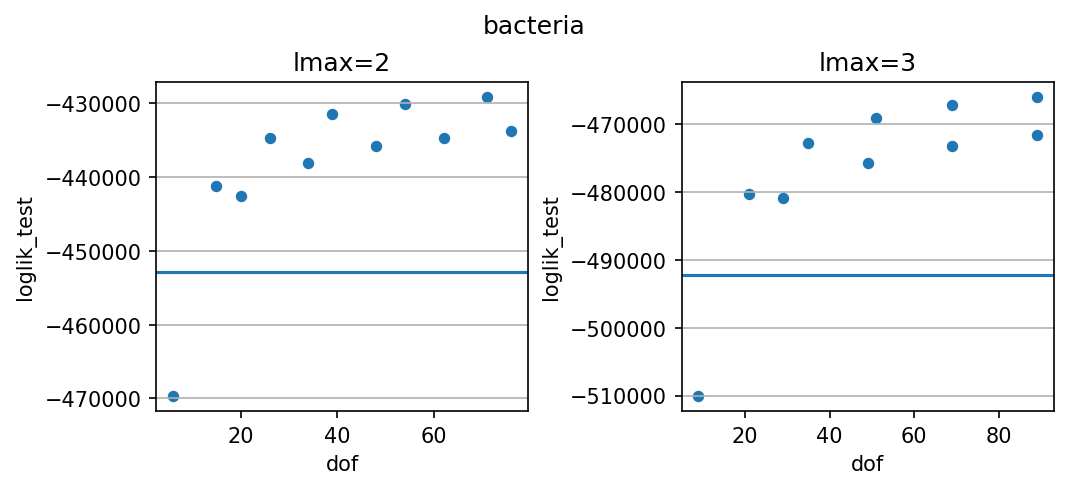

In [9]:
mm = 1 / 25.4

fig, axes = plt.subplots(1, 2, figsize=(178*mm, 80*mm), dpi=150, layout='constrained')
for (lmax, grp), ax in zip(result_bacteria.groupby('lmax'), axes):
    grp[grp['model'].eq('mmm'   )].plot.scatter(x='dof', y='loglik_test', ax=ax)    
    grp[grp['model'].eq('mirage')].plot.scatter(x='dof', y='loglik_test', ax=ax)
    ax.axhline(*grp.loc[grp['model'].eq('branch'), 'loglik_test'])
    ax.set_title(f'{lmax=}')
    ax.yaxis.grid()
fig.suptitle('bacteria')

In [10]:
result_fish = (
    loglik_fish
    .groupby(['conditionID', 'fold'], group_keys=False)
    .apply(lambda df: df.nlargest(1, 'loglik_train'))
    .groupby('conditionID')['loglik_test']
    .sum(min_count=5)
    .pipe(pd.merge, conditions, on='conditionID')
    .assign(dof=lambda df: df.apply(dof, axis=1, nbranch=nbranch_fish))
)

Text(0.5, 0.98, 'fish')

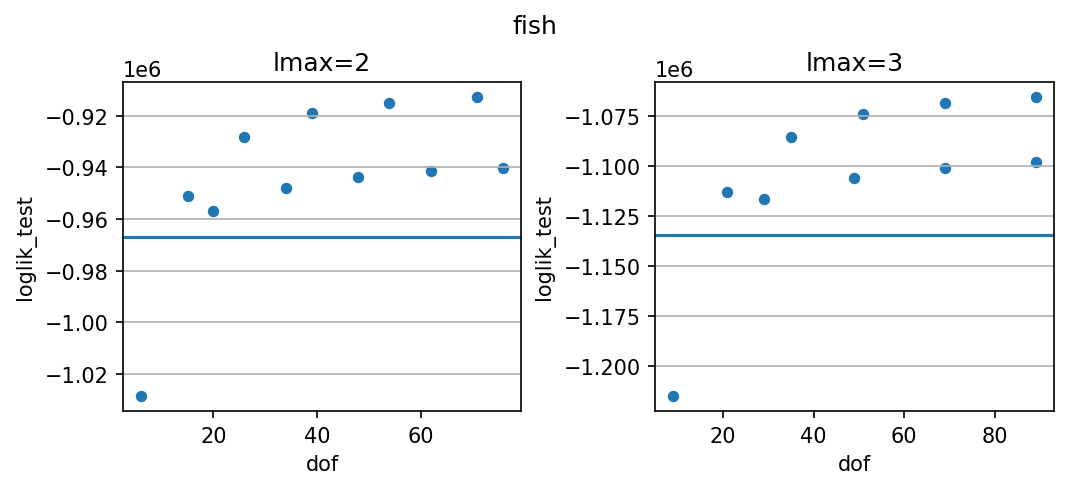

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(178*mm, 80*mm), dpi=150, layout='constrained')
for (lmax, grp), ax in zip(result_fish.groupby('lmax'), axes):
    grp[grp['model'].eq('mmm'   )].plot.scatter(x='dof', y='loglik_test', ax=ax)    
    grp[grp['model'].eq('mirage')].plot.scatter(x='dof', y='loglik_test', ax=ax)
    ax.axhline(*grp.loc[grp['model'].eq('branch'), 'loglik_test'])
    ax.set_title(f'{lmax=}')
    ax.yaxis.grid()
fig.suptitle('fish')

In [12]:
result_bacteria.to_csv(ROOT_DIR/'results'/'bacteria-CV-map.tsv', sep='\t')
result_fish.to_csv(ROOT_DIR/'results'/'fish-CV-map.tsv', sep='\t')